In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import plot.viz_sequence as viz_sequence
import pyBigWig
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import json
import tqdm
import h5py
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "binary"

In [3]:
# Shared paths/constants
raw_data_base_path = "/users/amtseng/att_priors/data/raw/"
proc_data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
tfm_results_path = "/users/amtseng/att_priors/results/tfmodisco/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"

In [ ]:
# K562
condition_name = "K562"
files_spec_path = os.path.join(proc_data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
num_tasks = 1
num_strands = 1
if model_type == "profile":
    controls = "shared"
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor

task_index = None
footprints_paths = [os.path.join(proc_data_base_path, "DNase_footprints/K562_tencol.bed.gz")]
noprior_model_path = os.path.join(model_base_path, "K562/10/model_ckpt_epoch_19.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/5/model_ckpt_epoch_18.pt")
noprior_tfm_path = os.path.join(tfm_results_path, "K562/K562_r10_e19_tfm.h5")
prior_tfm_path = os.path.join(tfm_results_path, "K562/K562_prior_r5_e18_tfm.h5")

In [4]:
# BPNet
condition_name = "BPNet"
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(proc_data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
if model_type == "profile":
    controls = "shared"
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor

bpnet_tasks = ["Nanog", "Oct4", "Sox2"]
task_index = 1

if task_index is None:
    footprints_paths = [
        os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_peaks-idr.bed.gz" % task.upper())
        for task in bpnet_tasks
    ]
    pos_bigwigs = [
        os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_pos.bw" % task.upper())
        for task in bpnet_tasks
    ]
    neg_bigwigs = [
        os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_neg.bw" % task.upper())
        for task in bpnet_tasks
    ]
else:
    footprints_paths = [os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_peaks-idr.bed.gz" % bpnet_tasks[task_index].upper())]
    pos_bigwigs = [os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_pos.bw" % bpnet_tasks[task_index].upper())]
    neg_bigwigs = [os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_neg.bw" % bpnet_tasks[task_index].upper())]
noprior_model_path = os.path.join(model_base_path, "BPNet/22/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/27/model_ckpt_epoch_11.pt")
noprior_tfm_path = os.path.join(tfm_results_path, "BPNet/BPNet_r22_e1_task%s_tfm.h5" % ("agg" if task_index is None else str(task_index)))
prior_tfm_path = os.path.join(tfm_results_path, "BPNet/BPNet_prior_r27_e11_task%s_tfm.h5" % ("agg" if task_index is None else str(task_index)))

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [6]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [7]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Import footprits
For BPNet, use the ChIP-nexus peaks, which can act as an easy proxy for footprints, althought they are very wide footprints

In [8]:
footprints = [
    pd.read_csv(
        path, sep="\t", header=None,
        names=[
            "chrom", "peak_start", "peak_end", "name", "score", "strand",
            "signal", "pval", "qval", "summit_offset"
        ]
    )
    for path in footprints_paths
]
footprints = pd.concat(footprints)
footprints = footprints[footprints["chrom"].isin(chrom_set)]

### Create reader for BigWigs
Only for something like BPNet, which has ChIP-nexus profiles, which offer a "continuous" view of footprint confidence, rather than a simple binary footprint classification

In [9]:
def get_profiles(chrom, start, end):
    """
    Returns N-array of BigWig values, as sum of negative and positive strands.
    """
    result = np.zeros((end - start, 2))
    for i in range(len(neg_bigwigs)):
        with pyBigWig.open(neg_bigwigs[i], "r") as f:
            result[:, 0] = f.values(chrom, start, end)
        with pyBigWig.open(pos_bigwigs[i], "r") as f:
            result[:, 1] = f.values(chrom, start, end)
    return np.sum(np.nan_to_num(result), axis=1)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model

In [10]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_set = data_loading.get_positive_profile_coords(
        files_spec_path, task_ind=task_index, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_set = data_loading.get_positive_binary_bins(
        files_spec_path, task_ind=task_index, chrom_set=chrom_set
    )

### Compute importances

In [11]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [12]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls,
            task_index=task_index
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, task_index=task_index
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [13]:
num_samples = 1000
rng = np.random.RandomState(20200318)
sample = pos_set[rng.choice(len(pos_set), size=num_samples, replace=False)]

In [14]:
# Get coordinates for the sample
if model_type == "profile":
    # For profile models, add a random jitter to avoid center-bias
    jitters = np.random.randint(-128, 128 + 1, size=len(sample))
    sample[:, 1] = sample[:, 1] + jitters
    sample[:, 2] = sample[:, 2] + jitters
    sample_coords = sample
else:
    sample_coords = input_func(sample)[2]

In [15]:
# Compute the importance scores and 1-hot seqs
imp_type = ("SHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "SHAP scores" else compute_gradients
noprior_imp_scores, sample_input_seqs = imp_func(
    noprior_model, sample
)
prior_imp_scores, _ = imp_func(
    prior_model, sample
)

In [16]:
# Pad the coordinates on both sides symmetrically to make them `input_length` 
centers = (sample_coords[:, 1] + sample_coords[:, 2]) // 2
starts = centers - (input_length // 2)
ends = starts + input_length
sample_coords[:, 1] = starts
sample_coords[:, 2] = ends

892 813595
Without priors:


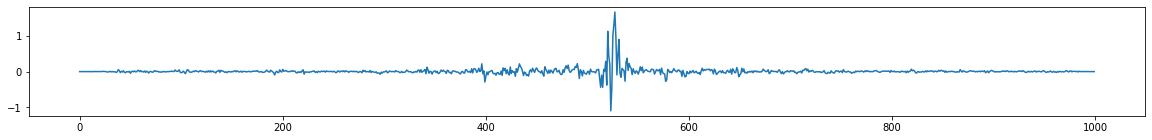

With priors:


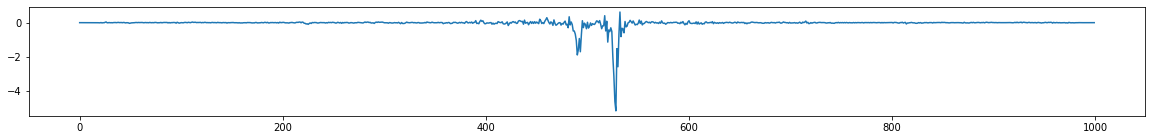

456 3644898
Without priors:


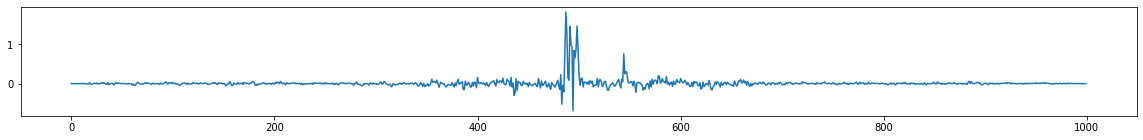

With priors:


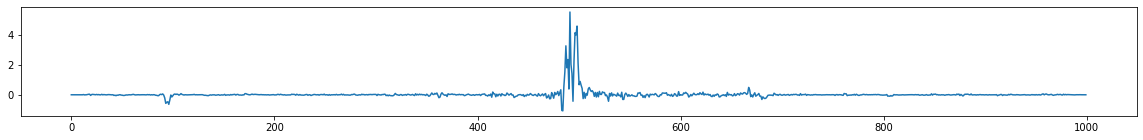

52 1037024
Without priors:


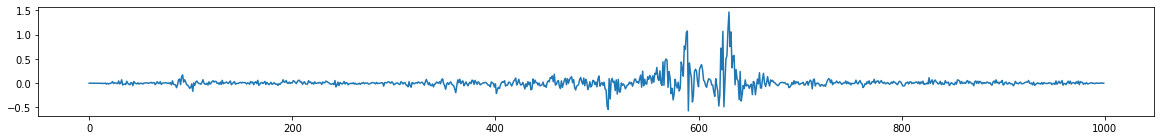

With priors:


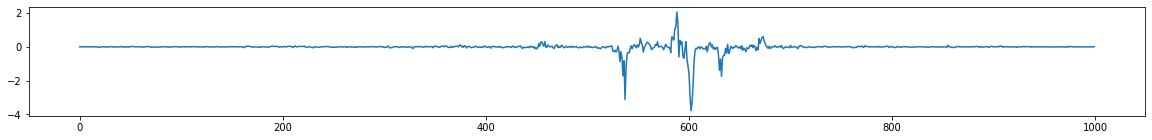

In [17]:
# Plot out a few examples
for i in np.random.choice(num_samples, size=3, replace=False):
    print(i, sample[i])
    print("=========================")
    print("Without priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(noprior_imp_scores[i] * sample_input_seqs[i], axis=1))
    plt.show()
    print("With priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(prior_imp_scores[i] * sample_input_seqs[i], axis=1))
    plt.show()

### Quantify agreement of importances with footprints using overlap
In each importance score track (over the entire input region), do the importances tend to be elevated more in known footprints?

In [18]:
def compute_footprint_overlap_amount(coords, score_tracks, footprints):
    """
    From an N x 3 object array of coordinates, a parallel N x I x 4 array
    of score tracks, and a table of imported footprints, this function computes
    and returns the overlap amount for each of the N examples, where the overlap
    for an example is the fraction of score magnitudes in its track that fall
    within a footprint. An overlap will be NaN if there are no footprints in the
    coordinate. Returns an N-array.
    """
    score_tracks = np.abs(score_tracks)  # Take absolute value of score tracks
    overlaps = np.empty(len(coords))
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        # Filter down the set of footprints to only those that overlap with the
        # coordinate
        fps = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        mask = np.zeros(end - start, dtype=bool)
        intervals = fps[["peak_start", "peak_end"]].values - start
        for interval in intervals:
            mask[interval[0]:interval[1]] = True
        if not np.sum(mask):
            overlaps[i] = np.nan
        else:
            overlaps[i] = np.sum(score_tracks[i][mask]) / np.sum(score_tracks[i])
    return overlaps

In [19]:
noprior_imp_fp_overlaps = compute_footprint_overlap_amount(
    sample_coords, noprior_imp_scores * sample_input_seqs, footprints
)
prior_imp_fp_overlaps = compute_footprint_overlap_amount(
    sample_coords, prior_imp_scores * sample_input_seqs, footprints
)

# Remove the NaNs, which is where no footprint was in the coordinate
noprior_imp_fp_overlaps = noprior_imp_fp_overlaps[np.isfinite(noprior_imp_fp_overlaps)]
prior_imp_fp_overlaps = prior_imp_fp_overlaps[np.isfinite(prior_imp_fp_overlaps)]

Average score without priors: 0.768043
Average score with priors: 0.792911
Test of difference of means: t = 9.647116, p = 0.000000


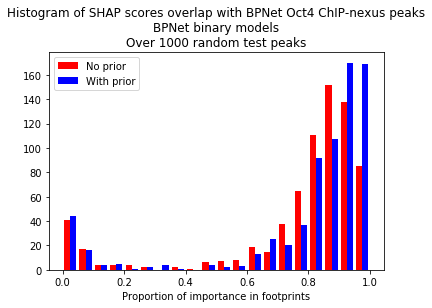

In [20]:
bin_num = 20
plt.figure()
plt.hist(
    [noprior_imp_fp_overlaps, prior_imp_fp_overlaps],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
if condition_name == "BPNet":
    title = "Histogram of %s overlap with BPNet %s ChIP-nexus peaks" % (imp_type, "aggregated" if task_index is None else bpnet_tasks[task_index])
else:
    title = "Histogram of %s overlap with %s footprints" % (imp_type, condition_name)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
plt.title(title)
plt.xlabel("Proportion of importance in footprints")
plt.legend()
print("Average score without priors: %f" % np.nanmean(noprior_imp_fp_overlaps))
print("Average score with priors: %f" % np.nanmean(prior_imp_fp_overlaps))
t, p = scipy.stats.ttest_rel(prior_imp_fp_overlaps, noprior_imp_fp_overlaps)
print("Test of difference of means: t = %f, p = %f" % (t, p / 2))

### Quantify agreement of importance windows with footprints using ranks
Rank all of the windows by importance; do the windows at the top tend to overlap with footprints?

In [21]:
def compute_single_footprint_overlap_mask(chrom, start, end, footprints):
    """
    Given a coordinate, returns a boolean mask for that coordinate
    for which bases lie within a footprint
    """
    mask = np.zeros(end - start, dtype=bool)
    for peak_bed in peak_beds:
        rows = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        intervals = rows[["peak_start", "peak_end"]].values - start
        for interval in intervals:
            mask[interval[0]:interval[1]] = True
    return mask

In [22]:
def compute_single_footprint_overlap_mask(chrom, start, end, footprints):
    """
    Given a coordinate, returns a boolean mask for that coordinate
    for which bases lie within a footprint
    """
    mask = np.zeros(end - start, dtype=bool)
    rows = footprints[
        (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
        (start <= footprints["peak_end"])
    ]
    intervals = rows[["peak_start", "peak_end"]].values - start
    for interval in intervals:
        mask[interval[0]:interval[1]] = True
    return mask

def compute_footprint_overlap_mask(coords, footprints):
    """
    Given a sample of N coordinates or bins, extracts a boolean mask
    denoting which locations in each sample overlap a footprint.
    Returns an N x I boolean array, where each subarray is a boolean mask
    for which bases in that coordinate lie within a footprint.
    """
    masks = []
    for coord in tqdm.notebook.tqdm(coords):
        # Pad to profile length
        masks.append(compute_single_footprint_overlap_mask(coord[0], coord[1], coord[2], footprints))
    return np.stack(masks, axis=0)

In [23]:
def compute_windowed_footprint_overlap_mask(scores, one_hot_seqs, seq_footprint_masks, window_size=10):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and identifies which windows overlap a footprint.
    Returns a boolean NumPy array denoting which windows overlap a peak, sorted in
    descending order of window importance, and the indices of each window. This requires
    a mask of whether or not each base in each input sequence overlaps a footprint,
    computed by `compute_footprint_overlap_mask`.
    """
    num_samples = len(scores)
    all_window_imps, all_footprint_masks = [], []
    all_window_inds = []
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        num_windows = len(score_track) - window_size + 1
        
        # Compute windowed peak mask
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        windowed_footprint_mask = seq_footprint_masks[i][window_locs.astype(int)]
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
            all_window_inds.append([i, j])
        
        all_window_imps.append(importances)
        all_footprint_masks.append(windowed_footprint_mask)
    
    window_imps, all_footprint_masks = np.concatenate(all_window_imps), np.concatenate(all_footprint_masks)
    all_window_inds = np.stack(all_window_inds)
    return all_footprint_masks[np.flip(np.argsort(window_imps))], all_window_inds[np.flip(np.argsort(window_imps))]

In [24]:
def normed_rank_enrichment(ordered_mask):
    """
    From a binary mask array (in order from best to worst thresholds), computes
    the rank enrichment at each threshold. Specifically, this computes a
    normalized CDF of how many 1s are seen in the first k instances.
    """
    cdf = np.cumsum(ordered_mask)
    # To normalize, divide by the expectation if there all 1s were spread
    # out evenly across the instances
    expectation = np.sum(ordered_mask) / len(ordered_mask) * np.arange(1, len(cdf) + 1)
    return cdf / expectation

In [25]:
window_size = 1

In [26]:
footprint_masks = compute_footprint_overlap_mask(sample_coords, footprints)
noprior_window_overlap_mask, noprior_windows = compute_windowed_footprint_overlap_mask(
    noprior_imp_scores, sample_input_seqs, footprint_masks, window_size=window_size
)
prior_window_overlap_mask, prior_windows = compute_windowed_footprint_overlap_mask(
    prior_imp_scores, sample_input_seqs, footprint_masks, window_size=window_size
)
noprior_window_overlap_cdf = normed_rank_enrichment(noprior_window_overlap_mask)
prior_window_overlap_cdf = normed_rank_enrichment(prior_window_overlap_mask)

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


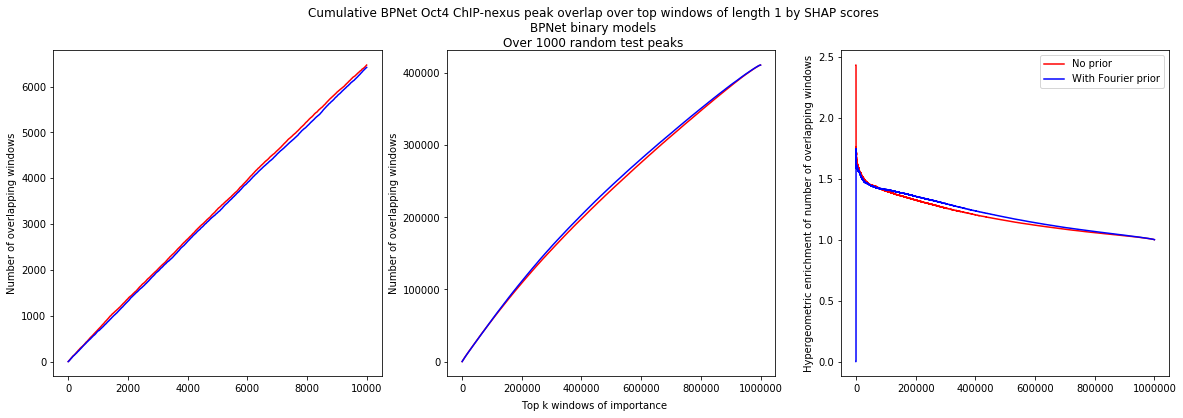

In [27]:
top_limit = 10000
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
if condition_name == "BPNet":
    title = "Cumulative BPNet %s ChIP-nexus peak overlap over top windows of length %d by %s" % ("aggregated" if task_index is None else bpnet_tasks[task_index], window_size, imp_type)
else:
    title = "Cumulative %s footprint overlap in top windows of length %d by %s" % (condition_name, window_size, imp_type)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_window_overlap_mask[:top_limit]), label="No prior", color="red")
ax[0].plot(np.cumsum(prior_window_overlap_mask[:top_limit]), label="With Fourier prior", color="blue")
ax[0].set_ylabel("Number of overlapping windows")
ax[1].plot(np.cumsum(noprior_window_overlap_mask), label="No prior", color="red")
ax[1].plot(np.cumsum(prior_window_overlap_mask), label="With Fourier prior", color="blue")
ax[1].set_ylabel("Number of overlapping windows")
ax[2].plot(noprior_window_overlap_cdf, label="No prior", color="red")
ax[2].plot(prior_window_overlap_cdf, label="With Fourier prior", color="blue")
ax[2].set_ylabel("Hypergeometric enrichment of number of overlapping windows")
fig.text(0.45, 0.05, "Top k windows of importance")
plt.legend()

### Quantify agreement of importance windows with profile-derived footprints using ranks
Rank all of the windows by importance; do the windows at the top tend to overlap with footprints? Instead of using pre-determined footprints, we use profile heights to binarize footprint classification

In [28]:
def compute_max_profile_heights(chrom, start, end, profile_func, flank_size=35):
    """
    Given a coordinate, returns the maximum profile height within the given flank
    size (to the left and right), for each base. Returns an array of size equal to
    the size of the coordinate.
    """
    max_heights = np.empty(end - start)
    heights = profile_func(chrom, start - flank_size, end + flank_size)
    for i in range(end - start):
        max_heights[i] = np.max(heights[i : i + (flank_size * 2)])
    return max_heights

def compute_footprint_overlap_mask_by_profile(coords, profile_func, flank_size=35, quant_cutoff=0.9):
    """
    Given an N x 3 object array of coordinates, extracts a boolean mask
    denoting which locations in each sample overlap a footprint, based on
    profile height. For each coordinate, this will look `flank_size` base pairs
    left and right of each base pair and record the maximum profile height seen.
    A base is deemed to overlie a footprint if its maximum profile height is in the
    `quant_cutoff` percentile (default 90th percentile) over all given bases given.
    Returns an N x I boolean array, where each subarray is a boolean mask for which
    bases in that coordinate lie within a footprint based on the profile height.
    """
    max_heights = []
    for coord in tqdm.notebook.tqdm(coords):
        max_heights.append(compute_max_profile_heights(coord[0], coord[1], coord[2], profile_func, flank_size))
    max_heights = np.stack(max_heights, axis=0)
    cutoff = np.sort(np.ravel(max_heights))[int(quant_cutoff * max_heights.size)]
    return max_heights >= cutoff

In [29]:
footprint_masks_by_profile = compute_footprint_overlap_mask_by_profile(sample_coords, get_profiles)
noprior_window_profoverlap_mask, noprior_windows = compute_windowed_footprint_overlap_mask(
    noprior_imp_scores, sample_input_seqs, footprint_masks_by_profile, window_size=window_size
)
prior_window_profoverlap_mask, prior_windows = compute_windowed_footprint_overlap_mask(
    prior_imp_scores, sample_input_seqs, footprint_masks_by_profile, window_size=window_size
)
noprior_window_profoverlap_cdf = normed_rank_enrichment(noprior_window_profoverlap_mask)
prior_window_profoverlap_cdf = normed_rank_enrichment(prior_window_profoverlap_mask)

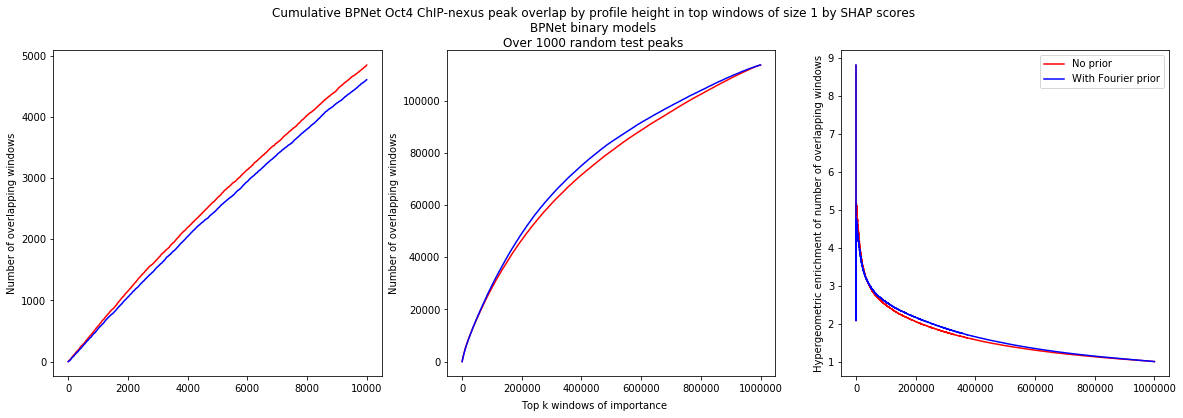

In [30]:
assert condition_name == "BPNet"
top_limit = 10000
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
title = "Cumulative BPNet %s ChIP-nexus peak overlap by profile height in top windows of size %d by %s" % ("aggregated" if task_index is None else bpnet_tasks[task_index], window_size, imp_type)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_window_profoverlap_mask[:top_limit]), label="No prior", color="red")
ax[0].plot(np.cumsum(prior_window_profoverlap_mask[:top_limit]), label="With Fourier prior", color="blue")
ax[0].set_ylabel("Number of overlapping windows")
ax[1].plot(np.cumsum(noprior_window_profoverlap_mask), label="No prior", color="red")
ax[1].plot(np.cumsum(prior_window_profoverlap_mask), label="With Fourier prior", color="blue")
ax[1].set_ylabel("Number of overlapping windows")
ax[2].plot(noprior_window_profoverlap_cdf, label="No prior", color="red")
ax[2].plot(prior_window_profoverlap_cdf, label="With Fourier prior", color="blue")
ax[2].set_ylabel("Hypergeometric enrichment of number of overlapping windows")
fig.text(0.45, 0.05, "Top k windows of importance")
plt.legend()

### Import the TF-MoDISco results

In [31]:
background_freqs = np.array([0.27, 0.23, 0.23, 0.27])
def pfm_info_content(pfm, pseudocount=0.001):
    """
    Given an L x 4 PFM, computes information content for each base and
    returns it as an L-array.
    """
    num_bases = pfm.shape[1]
    # Normalize track to probabilities along base axis
    pfm_norm = (pfm + pseudocount) / (np.sum(pfm, axis=1, keepdims=True) + (num_bases * pseudocount))
    ic = pfm_norm * np.log2(pfm_norm / np.expand_dims(background_freqs, axis=0))
    return np.sum(ic, axis=1)

def pfm_to_pwm(pfm, pseudocount=0.001):
    """
    Converts and L x 4 PFM into an L x 4 PWM.
    """
    num_bases = pfm.shape[1]
    # Incorporate pseudocount by adding it to every element and renormalizing
    pfm_norm = (pfm + pseudocount) / (np.sum(pfm, axis=1, keepdims=True) + (num_bases * pseudocount))
    return np.log2(pfm_norm / np.expand_dims(background_freqs, axis=0))

In [32]:
def revcomp_motif(motif):
    return np.flip(motif, axis=(0, 1))

In [33]:
def import_tfmodisco_motifs(
    tfm_results_hdf5, min_seqlets=750, min_ic=0.6, ic_window=6, trim_flank_ic_frac=0.2,
    plot_all_motifs=False, plot_passed_motifs=True
):
    """
    Imports the TF-MoDISco motifs, and a final set of motifs, trimmed by info content.
    The motifs returned must have at least `min_seqlets` supporting them, and there must
    be a window of size `ic_window` with at IC at least `min_ic`. Finally, the resulting
    motifs are trimmed by cutting off flanks whose base-level IC is below
    `trim_flank_ic_frac` of the highest IC of the motif. This also only keeps motifs with
    overall positive contributions (i.e. no negative seqlets).
    Returns 2 parallel lists: a list of motif CWMs, and a list of motif PWMs.
    """
    cwms, pwms = [], []
    num_seqlets = []
    with h5py.File(tfm_results_hdf5, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if plot_all_motifs:
                print("Metacluster: %s (%d/%d)" % (metacluster_key, metacluster_i + 1, num_metaclusters))
                print("==========================================")
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                seqlets = pattern["seqlets_and_alnmts"]["seqlets"]
                
                if plot_all_motifs:
                    print("Pattern: %s (%d/%d)" % (pattern_name, pattern_i + 1, num_patterns))
                    print("--------------------------------------")

                    print("%d seqlets" % len(seqlets))
                    print("Sequence")
                    viz_sequence.plot_weights(pattern["sequence"]["fwd"][:])
                    print("Hypothetical contributions")
                    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"][:])
                    print("Contribution_scores")
                    viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"][:])
                
                pfm = pattern["sequence"]["fwd"][:]
                act_contribs = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if np.sum(act_contribs) < 0:
                    continue
                
                # Check number of seqlets and IC
                if len(seqlets) < min_seqlets:
                    continue
                
                pwm = pfm_to_pwm(pfm)
                pwm_ic = pfm_info_content(pfm)
                max_windowed_ic = max(
                    np.sum(pwm_ic[i : (i + ic_window)]) for i in range(len(pwm_ic) - ic_window + 1)
                )
                if max_windowed_ic / ic_window < min_ic:
                    continue
                    
                # Cut off flanks from actual contribution scores and PWM based on IC of PWM
                ic_trim_thresh = np.max(pwm_ic) * trim_flank_ic_frac
                pass_inds = np.where(pwm_ic >= ic_trim_thresh)[0]
                trimmed_cwm = act_contribs[np.min(pass_inds): np.max(pass_inds) + 1]
                trimmed_pwm = pwm[np.min(pass_inds): np.max(pass_inds) + 1]
                
                # Last check to make sure motif is overall positive
                if np.sum(trimmed_cwm) < 0:
                    continue

                cwms.append(trimmed_cwm)
                pwms.append(trimmed_pwm)
                num_seqlets.append(len(seqlets))

    if plot_passed_motifs:
        print("Final motifs: %d total" % len(cwms))
        print("==========================================")
        for i in range(len(cwms)):
            print("Motif %d (%d seqlets)" % (i + 1, num_seqlets[i]))
            viz_sequence.plot_weights(cwms[i])
            viz_sequence.plot_weights(pwms[i])
    return cwms, pwms

Final motifs: 4 total
Motif 1 (5998 seqlets)


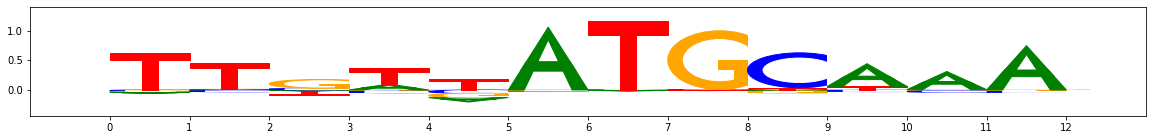

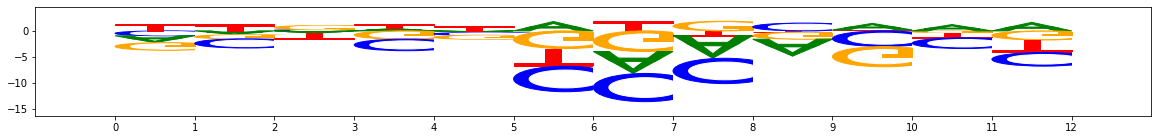

Motif 2 (1295 seqlets)


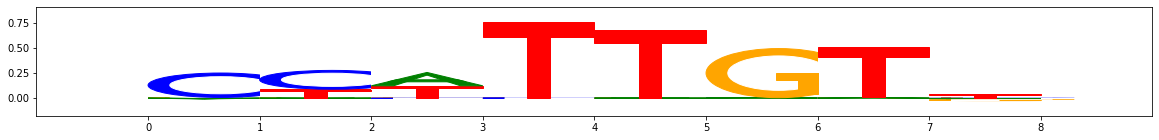

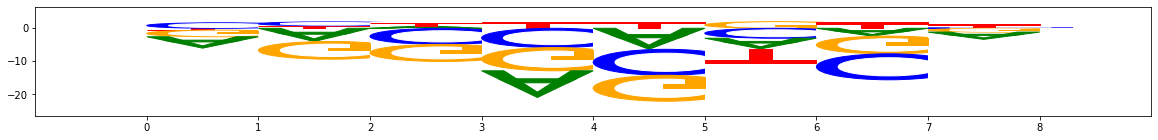

Motif 3 (902 seqlets)


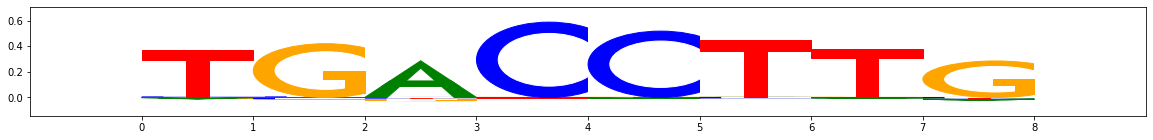

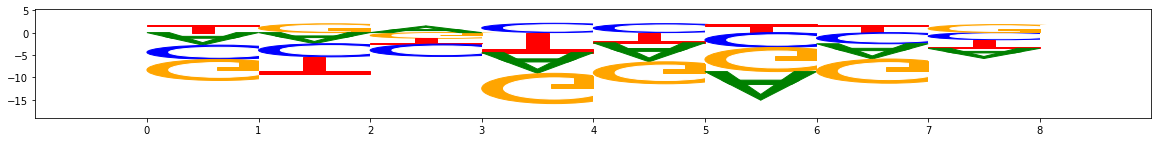

Motif 4 (771 seqlets)


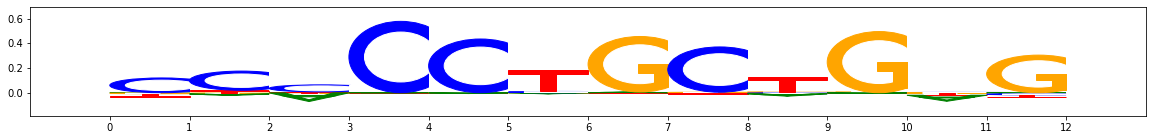

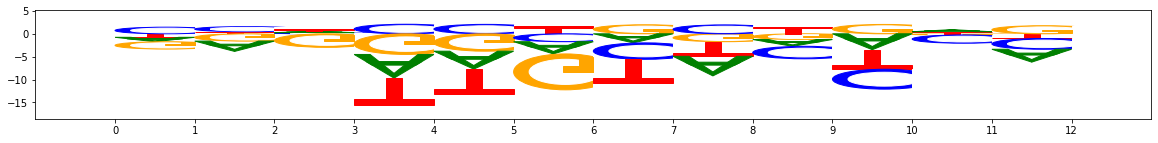

In [34]:
noprior_cwms, noprior_pwms = import_tfmodisco_motifs(noprior_tfm_path, plot_all_motifs=False, plot_passed_motifs=True)

Final motifs: 3 total
Motif 1 (3766 seqlets)


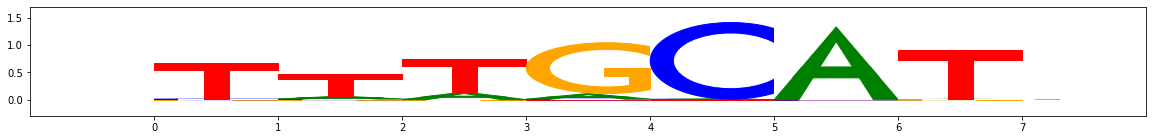

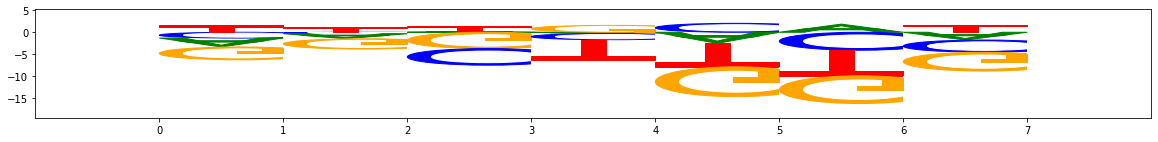

Motif 2 (2164 seqlets)


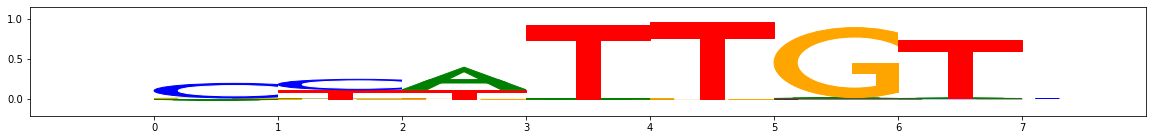

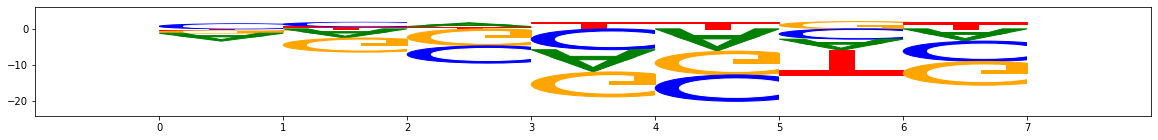

Motif 3 (1136 seqlets)


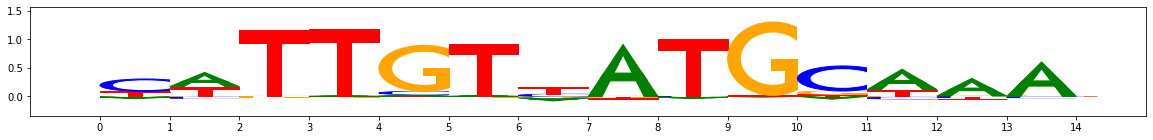

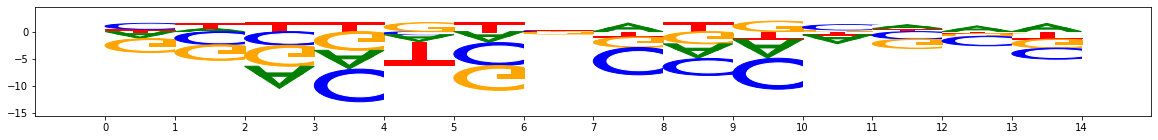

In [35]:
prior_cwms, prior_pwms = import_tfmodisco_motifs(prior_tfm_path, plot_all_motifs=False, plot_passed_motifs=True)

### Call motif instances

In [36]:
def jaccard_sim(seq_1, seq_2, normalize=True):
    """
    Takes two windows (W x 4 arrays) and computes a similarity between them,
    using a continuous Jaccard metric. If `normalize` is True, L1 normalizes
    both sequences first.
    """
    if normalize:
        seq_1 = seq_1 / np.sum(np.abs(seq_1))
        seq_2 = seq_2 / np.sum(np.abs(seq_2))
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2)
    union = np.maximum(ab_1, ab_2)
    cont_jaccard = np.sum(inter, axis=1) / np.sum(union, axis=1)
    return np.sum(cont_jaccard)

In [37]:
def call_motifs(coords, imp_scores, one_hot_seqs, cwms, pwms, top_contrib_frac=0.1):
    """
    From an N x 3 object array of coordinates and parallel N x I x 4 array
    of actual importance scores, this calls motifs based on Jaccard similarity.
    For each motif in `cwms` and `pwms`, scans to find the best instances. Returns
    the result of all scans (over all motifs together) as an M x 3 object array
    of instance coordinates, a parallel M-array of match scores, and an M-array
    of CWM source indices, all in reverse order by match score.
    """
    assert len(coords) == len(imp_scores)
    assert np.all(coords[:, 2] - coords[:, 1] == input_length), \
        "Expect all coordinates to be of length %d" % input_length
    assert imp_scores.shape[1] == input_length, \
        "Expect important scores to have sequence length %d" % input_length
    
    # Allocate arrays
    array_len = 0
    for cwm in cwms:
        num_windows_per_coord = input_length - len(cwm) + 1
        array_len += num_windows_per_coord * len(coords)
    motif_coords = np.empty((array_len, 3), dtype=object)
    cwm_scores = np.empty(array_len)  # CWM match score; for ranking at the end
    pwm_scores = np.empty(array_len)  # PWM match score; for filtering
    motif_sources = np.empty(array_len, dtype=int)
    contrib_scores = np.empty(array_len)  # Total contribution score; for filtering
    
    next_index = 0
    # For each coordinate, for each CWM, for each window, compute the match
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        imp_score_track = imp_scores[i]
        one_hot_seq_track = one_hot_seqs[i]
            
        for motif_i in range(len(cwms)):
            cwm, pwm = cwms[motif_i], pwms[motif_i]
            rc_cwm, rc_pwm = revcomp_motif(cwm), revcomp_motif(pwm)
            motif_len = len(cwm)
            num_windows_per_coord = input_length - motif_len + 1

            for j in range(num_windows_per_coord):
                motif_coords[next_index, 0] = chrom
                motif_coords[next_index, 1] = start + j
                motif_coords[next_index, 2] = start + j + motif_len
                imp_score_window = imp_score_track[j:(j + motif_len)]
                one_hot_seq_window = one_hot_seq_track[j:(j + motif_len)]
                fwd_score, rev_score = jaccard_sim(imp_score_window, cwm), jaccard_sim(imp_score_window, rc_cwm)
                if fwd_score > rev_score:
                    cwm_scores[next_index] = fwd_score
                    pwm_scores[next_index] = np.sum(one_hot_seq_window * pwm)
                else:
                    cwm_scores[next_index] = rev_score
                    pwm_scores[next_index] = np.sum(one_hot_seq_window * rc_pwm)
                motif_sources[next_index] = motif_i
                contrib_scores[next_index] = np.sum(np.abs(imp_score_window))
                next_index += 1

    # Filter out anything with a negative PWM match score
    mask = pwm_scores > 0
    motif_coords = motif_coords[mask]
    cwm_scores = cwm_scores[mask]
    motif_sources = motif_sources[mask]
    contrib_scores = contrib_scores[mask]
    
    # For each CWM, keep only the top few based on CWM match score
    mask = np.zeros(len(motif_sources), dtype=bool)
    for cwm_i in range(len(cwms)):
        cwm_mask = motif_sources == cwm_i
        cwm_match_scores = cwm_scores[cwm_mask]
        limit = np.flip(np.sort(cwm_match_scores))[int(len(cwm_match_scores) * top_contrib_frac)]
        mask = mask | (cwm_mask & (cwm_scores >= limit))  # Update mask for wherever it is this CWM and score in top %ile
    motif_coords = motif_coords[mask]
    cwm_scores = cwm_scores[mask]
    motif_sources = motif_sources[mask]
    contrib_scores = contrib_scores[mask]
    
    # Now order by contribution score
    inds = np.flip(np.argsort(contrib_scores))
    return motif_coords[inds], cwm_scores[inds], motif_sources[inds]

In [38]:
noprior_motif_call_coords, noprior_cwm_scores, noprior_motif_sources = call_motifs(
    sample_coords, (noprior_imp_scores * sample_input_seqs), sample_input_seqs, noprior_cwms, noprior_pwms
)
prior_motif_call_coords, prior_cwm_scores, prior_motif_sources = call_motifs(
    sample_coords, (prior_imp_scores * sample_input_seqs), sample_input_seqs, prior_cwms, prior_pwms
)

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater_equal


### Quantify agreement of motif instances with footprints using ranks

In [39]:
def compute_footprint_overlap(coords, footprints):
    """
    From an N x 3 object array of coordinates and a table of imported footprints,
    this function determines which coordinates overlap with a footprint.
    Returns a N-array binary mask, denoting which coordinates overlap with a
    footprint.
    """
    mask = np.zeros(len(coords), dtype=int)
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        fps = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        if len(fps):
            mask[i] = 1
    return mask

In [40]:
noprior_motif_overlap_mask = compute_footprint_overlap(
    noprior_motif_call_coords[:10000], footprints
)
prior_motif_overlap_mask = compute_footprint_overlap(
    prior_motif_call_coords[:10000], footprints
)
noprior_motif_overlap_cdf = normed_rank_enrichment(noprior_motif_overlap_mask)
prior_motif_overlap_cdf = normed_rank_enrichment(prior_motif_overlap_mask)

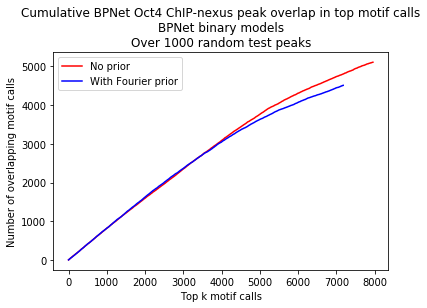

In [41]:
plt.figure()
if condition_name == "BPNet":
    title = "Cumulative BPNet %s ChIP-nexus peak overlap in top motif calls" % ("aggregated" if task_index is None else bpnet_tasks[task_index])
else:
    title = "Cumulative %s footprint overlap in top motif calls" % condition_name
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
plt.title(title)
plt.plot(np.cumsum(noprior_motif_overlap_mask), label="No prior", color="red")
plt.plot(np.cumsum(prior_motif_overlap_mask), label="With Fourier prior", color="blue")
plt.ylabel("Number of overlapping motif calls")
plt.xlabel("Top k motif calls")
plt.legend()

### Quantify agreement of motif instances with profile-derived footprints using ranks
Instead of using pre-determined footprints, we use profile heights to binarize footprint classification

In [42]:
def binarize_footprints_by_profiles(coords, profile_func, flank_size=35, quant_cutoff=0.9):
    """
    Given an N x 3 object array of coordinates and a function that returns
    the profile given any coordinate (chrom, start, and end), determines
    which of the N coordinates overlie a footprint, based on profile counts.
    For each coordinate, this will look `flank_size` base pairs left and right
    of the center, and record the maximum profile height seen. A coordinate is
    deemed to overlie a footprint if its maximum profile height is in the
    `quant_cutoff` percentile (default 90th percentile) over all given
    coordinates. Returns an N-array as a binary mask of which centers overlie a
    footprint.
    """
    heights = np.empty(len(coords))
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        center = (start + end) // 2
        heights[i] = np.max(
            profile_func(chrom, center - flank_size, center + flank_size)
        )
    inds = np.flip(np.argsort(heights))  # Best (highest) height first
    num_keep = int(quant_cutoff * len(coords))
    mask = np.zeros(len(coords), dtype=int)
    mask[inds[:num_keep]] = 1
    return mask

In [43]:
noprior_motif_profoverlap_mask = binarize_footprints_by_profiles(
    noprior_motif_call_coords[:10000], get_profiles
)
prior_motif_profoverlap_mask = binarize_footprints_by_profiles(
    prior_motif_call_coords[:10000], get_profiles
)
noprior_motif_profoverlap_cdf = normed_rank_enrichment(noprior_motif_profoverlap_mask)
prior_motif_profoverlap_cdf = normed_rank_enrichment(prior_motif_profoverlap_mask)

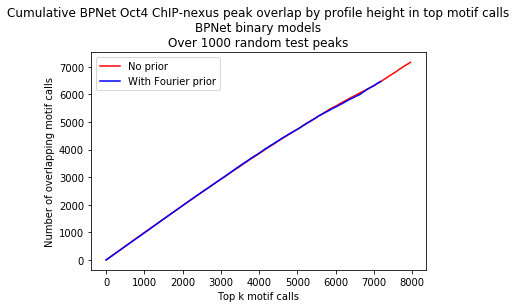

In [44]:
assert condition_name == "BPNet"
plt.figure()
title = "Cumulative BPNet %s ChIP-nexus peak overlap by profile height in top motif calls" % ("aggregated" if task_index is None else bpnet_tasks[task_index])
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
plt.title(title)
plt.plot(np.cumsum(noprior_motif_profoverlap_mask), label="No prior", color="red")
plt.plot(np.cumsum(prior_motif_profoverlap_mask), label="With Fourier prior", color="blue")
plt.ylabel("Number of overlapping motif calls")
plt.xlabel("Top k motif calls")
plt.legend()